In [1]:
import torchtext
from torchtext.vocab import Vectors, GloVe
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from submission.models import *
from submission.helpers import *
from evaluation import *

In [2]:
# Our input $x$
TEXT = torchtext.data.Field()
    
# Our labels $y$
LABEL = torchtext.data.Field(sequential=False)


train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL,
    filter_pred=lambda ex: ex.label != 'neutral')

# Build vocab
TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
(train, val, test), batch_size=11, device=-1)

# Build the vocabulary with word embeddings
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

In [3]:
class MultinomialNB(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(MultinomialNB, self).__init__()
        self._TEXT = TEXT
        self._LABEL = LABEL
        self._text_vocab_len = len(self._TEXT.vocab)        
        self.n_positive = 0
        self.n_negative = 0
        # Smoothing para is 1 for all features
        self.p = torch.ones(self._text_vocab_len)
        self.q = torch.ones(self._text_vocab_len)
        self.r = None
        self.index_pos = LABEL.vocab.itos.index('positive')
        self.index_neg = LABEL.vocab.itos.index('negative')

    # could use EmbeddingsBag, but there's not a huge difference in
    # performance
    def get_features(self, batch):
        size_batch = batch.size()[0]
        features = torch.zeros(size_batch, self._text_vocab_len)
        for i in range(size_batch):
            for j in batch[i, :]:
                features[i, j.data[0]] += 1
        return features
        # return torch.Tensor(features)

    def train(self, train_iter):
        # There's probably a better way to do this
        num_iter = len(train_iter)
        train_iter = iter(train_iter)
        for i in range(num_iter):
            batch = next(train_iter)
            if i % 100 == 0:
                print(i)
            # Should be [N, num-features]
            features = self.get_features(torch.t(batch.text).contiguous())

            # Using broadcasting
            inds_pos = torch.nonzero(batch.label.data == self.index_pos)
            inds_neg = torch.nonzero(batch.label.data == self.index_neg)


            if inds_pos.size():
                self.n_positive += inds_pos.size()[0]
                self.p = torch.add(self.p, torch.sum(features[inds_pos, :], dim=0))                
            if inds_neg.size():
                self.n_negative += inds_neg.size()[0]
                self.q = torch.add(self.q, torch.sum(features[inds_neg, :], dim=0))

            # print(features)
            # print(inds_neg, inds_pos)
            # print(self.p.size(), torch.sum(features, dim=0).size())

        self.r = torch.log((self.p / self.p.sum()) / (self.q / self.q.sum()))
        
    def forward(self, batch):
        # for k in range(batch_text.size()[1]):
        features = self.get_features(batch)
        # Using broadcasting
        return torch.matmul(features, torch.squeeze(self.r)) + \
            np.log(self.n_positive / self.n_negative)

In [4]:
model = MultinomialNB(TEXT, LABEL)
model.train(train_iter)

0
100
200
300
400
500
600


Iteration 0, loss: 1.098328
Iteration 100, loss: 0.684586
Iteration 200, loss: 0.503818
Iteration 300, loss: 0.568563
Iteration 400, loss: 0.538313
Iteration 500, loss: 0.661135
Iteration 600, loss: 0.661425
Iteration 700, loss: 0.456147
Iteration 800, loss: 0.585208
Iteration 900, loss: 0.517305


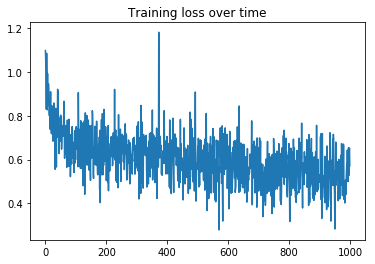

In [29]:
model = LogisticRegression(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, model)
trainer.train(train_iter)

In [7]:
class TextEvaluator(object):
    def __init__(self, model):
        self._predictions = []
        self._model = model

    def score(self, test_iter, predictions_file=""):
        correct = 0
        total = 0
        for i,batch in enumerate(test_iter):
            # Get predictions
            probs = self._model(torch.t(batch.text).contiguous())
            if len(probs.size()) == 1 or (len(probs.size()) == 2 \
                                          and probs.size()[1] == 1):
                signs = torch.sign(probs).type(torch.LongTensor)
                classes = (signs + 1) * (self._model.index_pos - self._model.index_neg) / 2 + \
                          self._model.index_neg
                # print(classes, probs)
            else:
                _, argmax = probs.max(1)
                classes = argmax.data
            if i % 100 == 0:
                print('Iteration %d, predictions:' % (i), list(classes))
            self._predictions += list(classes)

            correct += (classes == batch.label.data).sum()
            total += len(batch.label.data)

        print("Accuracy:", correct, total, correct/total)
        if predictions_file:
            with open(predictions_file, "w") as f:
                f.write("Id,Cat\n")
                for index,p in enumerate(self._predictions):
                    f.write(str(index) + "," + str(p) + "\n")

            

In [8]:
evaluator = TextEvaluator(model)
evaluator.score(test_iter)

Iteration 0, predictions: [1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2]
Accuracy: 1500 1821 0.8237232289950577


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  if __name__ == '__main__':


In [54]:
class TextTrainer(object):
    def __init__(self, TEXT, LABEL, model):
        # NLLLoss works with labels, not 1-hot encoding
        self._loss_fn = nn.NLLLoss()
        self._optimizer = optim.SGD(filter(lambda p : p.requires_grad,
                                           model.parameters()), lr=0.1)
        self._TEXT = TEXT
        self._LABEL = LABEL
        self._text_vocab_len = len(self._TEXT.vocab)
        self._model = model
        
        # For review and assessment
        self._training_losses = []

    # TODO: this is horribly slow, can use nn.EmbeddingsBag and put
    # this in LogisticRegression class!
    def get_feature(self, batch):
        # Need transpose so that batch size is first dimension; need
        # contiguous because of the transpose
        return torch.t(batch.text.data).contiguous()
        # size_batch = batch.text.size()[1]
        # features = torch.zeros(size_batch, self._text_vocab_len)
        # for i in range(size_batch):
        #     for j in batch.text[:, i]:
        #         features[i, j.data[0]] += 1
        # return features
    
    def get_label(self, batch):
        return batch.label.data
    
    def make_loss(self, batch):
        bow = autograd.Variable(self.get_feature(batch))
        label = autograd.Variable(self.get_label(batch))
        loss = F.cross_entropy(self._model(bow), label)
        return loss
    
    def train(self, train_iter, num_iter=1000, skip_iter=100, plot=True):
        for i in range(num_iter):
            batch = next(iter(train_iter))
            self._model.zero_grad()
            loss = self.make_loss(batch)
            
            loss_val = loss.data.numpy()[0] 
            self._training_losses.append(loss_val)
            if i % skip_iter == 0:
                print('Iteration %d, loss: %f' % (i, loss_val))
            loss.backward()
            self._optimizer.step()
        if plot:
            plt.plot(np.arange(len(self._training_losses)), self._training_losses)
            plt.title("Training loss over time")
            plt.show()


In [55]:
class CNN(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(CNN, self).__init__()
        
        N = TEXT.vocab.vectors.size()[0]
        D = TEXT.vocab.vectors.size()[1]
        print(D)
        C = len(LABEL.vocab)
        in_channels = 1
        out_channels = 100 #args.kernel_num
        kernel_sizes = [2,3] #args.kernel_sizes
        
        self.embeddings = nn.Embedding(N, D)
        self.embeddings.weight = nn.Parameter(TEXT.vocab.vectors, requires_grad=True)
        
        # Linear layer
        self.linear = nn.Linear(TEXT.vocab.vectors.size()[1], len(LABEL.vocab))

        self.embed = nn.Embedding(N, D)
        # self.convs1 = [nn.Conv2d(in_channels, out_channels, (K, D)) for K in Ks]
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channels, out_channels, (K, D)) for K in kernel_sizes])
        '''
        self.conv13 = nn.Conv2d(Ci, Co, (3, D))
        self.conv14 = nn.Conv2d(Ci, Co, (4, D))
        self.conv15 = nn.Conv2d(Ci, Co, (5, D))
        '''
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(kernel_sizes)*out_channels, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embeddings(x)  # (N, W, D)
#         if self.args.static:
#             x = Variable(x)

        x = x.unsqueeze(1)  # (N, in_channels, W, D)
    
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        '''
        x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
        x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
        x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
        x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = F.log_softmax(self.fc1(x), dim=1)  # (N, C)
        return logit

300
Iteration 0, loss: 1.110333
Iteration 100, loss: 0.769454
Iteration 200, loss: 0.769596
Iteration 300, loss: 0.691201
Iteration 400, loss: 0.714860
Iteration 500, loss: 0.702560
Iteration 600, loss: 0.702381
Iteration 700, loss: 0.707905
Iteration 800, loss: 0.699417
Iteration 900, loss: 0.709446


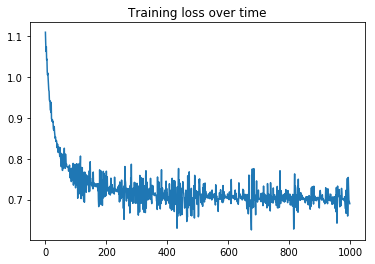

In [56]:
model = CNN(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, model)
trainer.train(train_iter)

In [57]:
evaluator = TextEvaluator(model)
evaluator.score(test_iter)

Iteration 0, predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Iteration 100, predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 909 1821 0.49917627677100496


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  if __name__ == '__main__':
